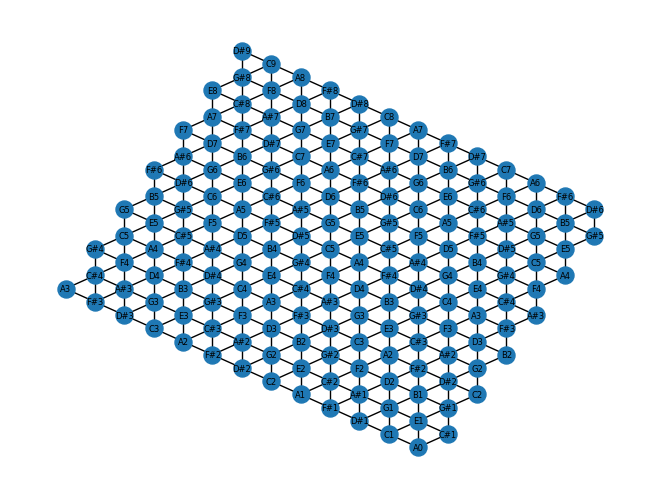

In [1]:
import random

import matplotlib.pyplot as plt

from tonnetz import Tonnetz
t = Tonnetz()
t.draw()

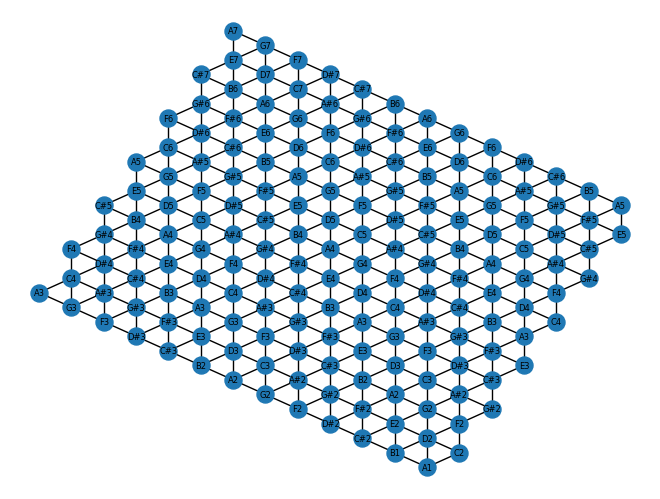

In [2]:
t = Tonnetz((2,3,7))
t.draw()

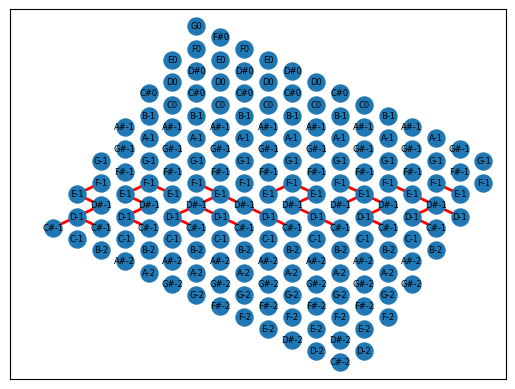

In [4]:
from tonnetz import TonnetzSong

ts = TonnetzSong((1,1,10), start_note=1)
ts.analyze([1, 2, 3, 4, 5])
ts.draw()


['C4', 'C4', 'G4', 'G4', 'A4', 'A4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4', 'D4', 'C4']


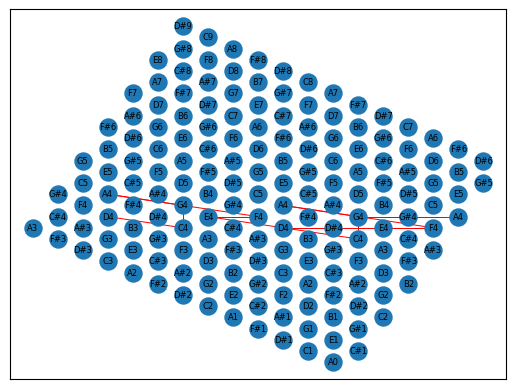

In [5]:
from song import SimpleSong
import matplotlib

s = SimpleSong("csvs/test.csv")
print(s)

ts2 = TonnetzSong()

ts2.analyze(s.notes)
ts2.draw()

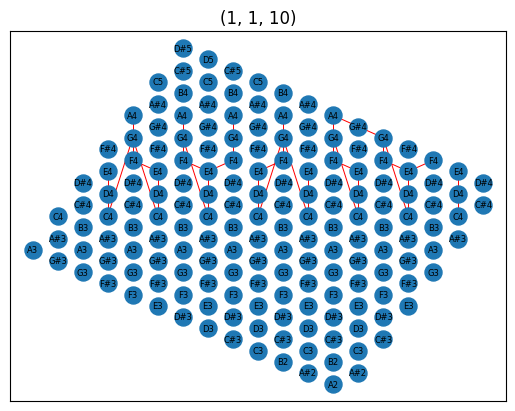

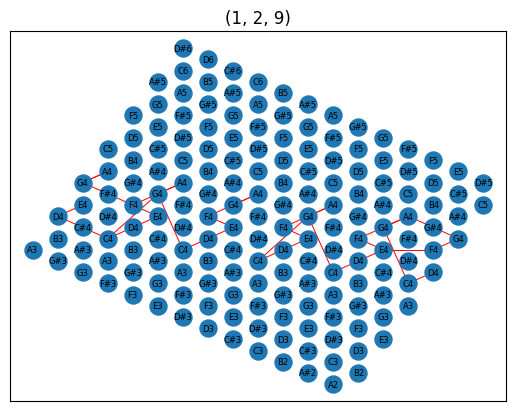

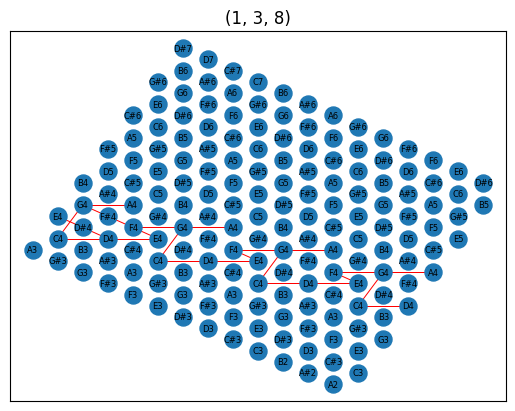

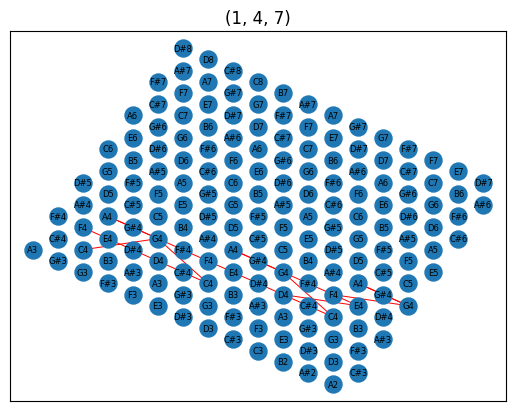

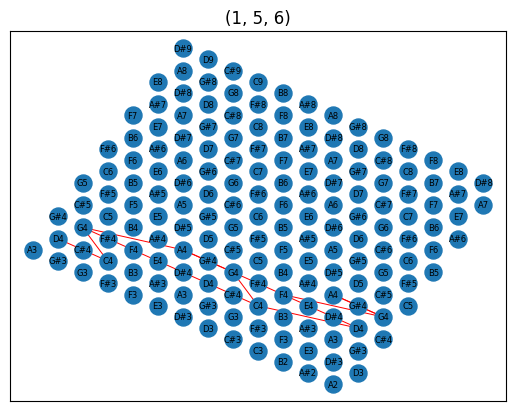

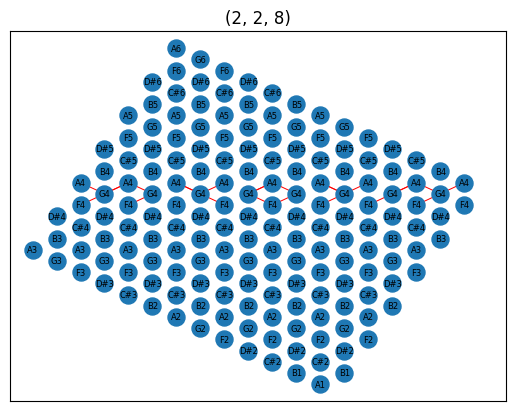

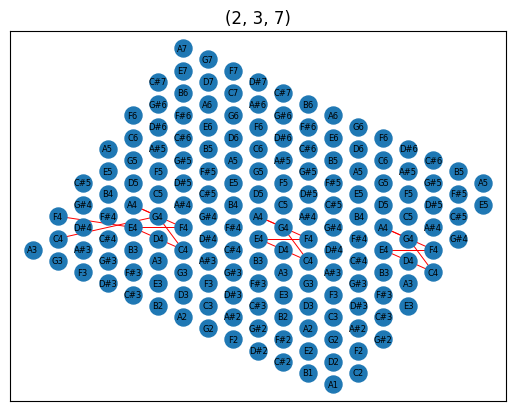

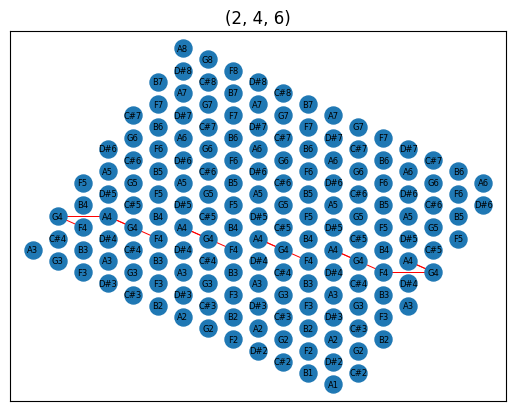

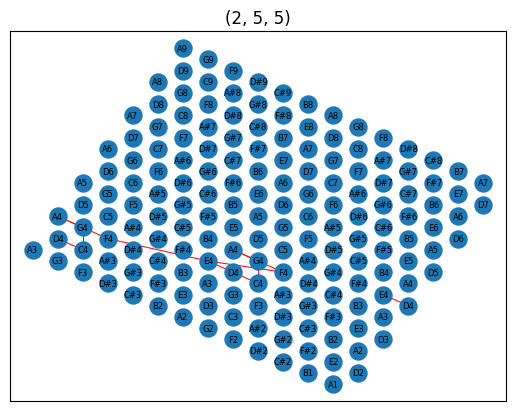

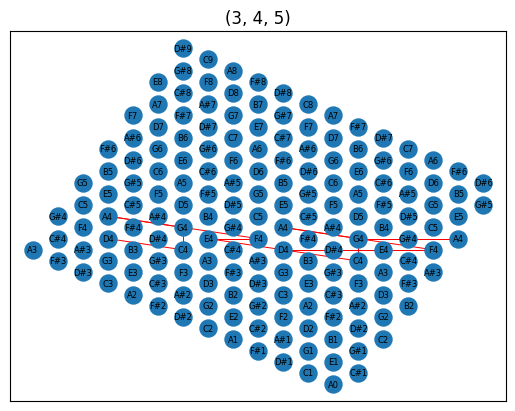

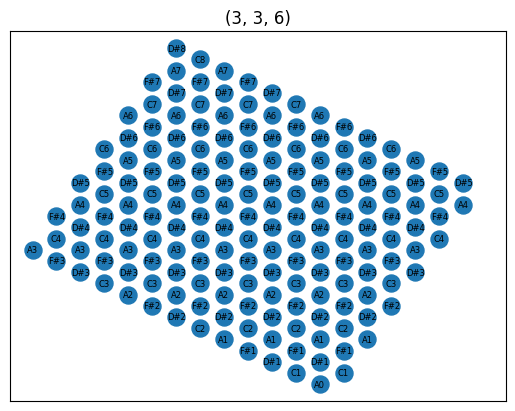

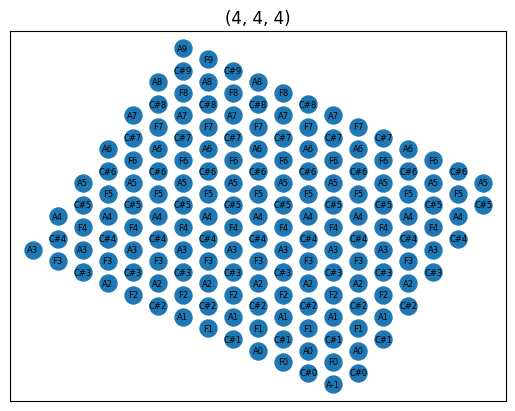

<Figure size 640x480 with 0 Axes>

In [6]:
from tonnetz import TONNETZ_INTERVALS

for interval in TONNETZ_INTERVALS:
    ts = TonnetzSong(intervals=interval)
    ts.analyze(s.notes)
    matplotlib.pyplot.title(f"{interval}")
    ts.draw()
    
    matplotlib.pyplot.figure()

## Note Transitions from MIDI file
Getting Note transitions when multiple notes are being played at once?

In [7]:
# Isolate Melody 

import mido

path = "data/clean_midi/ABBA/Dancing Queen.mid"
midi_file = mido.MidiFile(path, clip=True)

melody_track = None
for t in midi_file.tracks:
    if t.name == "Melody":
        melody_track = t
        
melody = mido.MidiFile()
melody.tracks.append(melody_track)

melody.save("data/test/DancingQueenMelody1.mid")


FileNotFoundError: [Errno 2] No such file or directory: 'data/test/DancingQueenMelody1.mid'

In [8]:
import os

ABBA_DIR = "data/clean_midi/ABBA/"
filteredPaths = []
# for path in sorted(os.listdir(ABBA_DIR)):
#     if any(char.isdigit() for char in path):
#         continue
#     try:
#         midi_file = mido.MidiFile(ABBA_DIR + path)
#         print(f"{path}, {midi_file.type}, {len(midi_file.tracks)}, {midi_file.length}")
#         if midi_file.type != 2:
#             # Ignore more complicated songs that have multiple independent tracks
#             filteredPaths.append(path)
#     except Exception as e:
#         print(f"{path}: {e}")
        
print(filteredPaths)

[]


In [9]:
import mido
dq = mido.MidiFile(ABBA_DIR + "Dancing Queen.mid")
# print(dq.tracks[3])

TRANSITION_COUNT_THRESH = 10 # Track must have at least 10 note transitions

def track_to_notes(track: mido.MidiTrack):
    notes = []
    last_note = None
    transitions = 0
    for msg in track:
        if msg.type == "note_on" and msg.velocity != 0:
            notes.append(msg.note)
            if msg.note != last_note:
                last_note = msg.note
                transitions += 1
            
    if transitions < TRANSITION_COUNT_THRESH: return []
    return notes


## Type 1 Song

Pretty good separation of elements in `type=1` song, which has separate tracks for each element

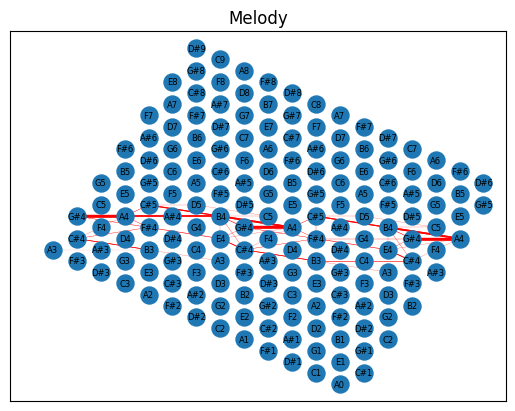

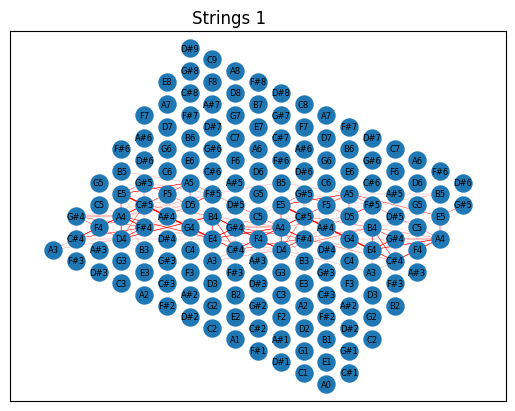

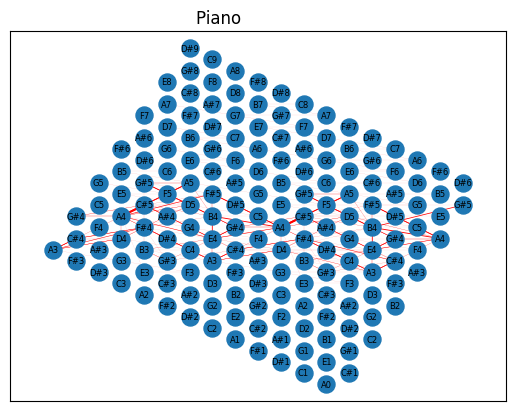

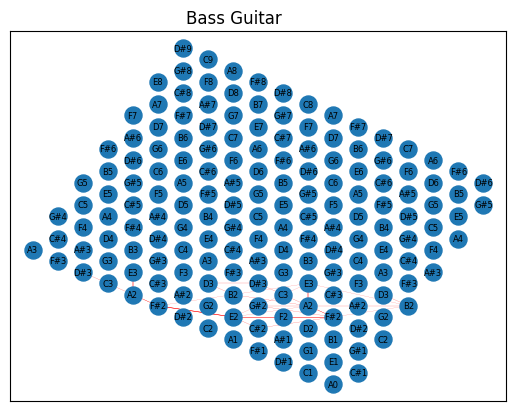

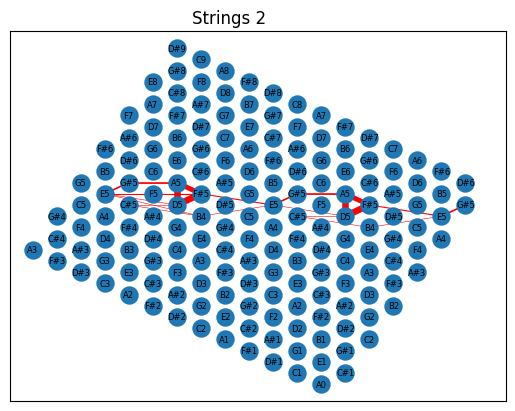

<Figure size 640x480 with 0 Axes>

In [10]:
from tonnetz import TonnetzSong
import matplotlib.pyplot as plt

for track in dq.tracks:
    ts = TonnetzSong()
    notes = track_to_notes(track)
    if len(notes) == 0:
        continue
    ts.analyze(notes)
    plt.title(f"{track.name}")
    ts.draw(edge_width_adjust=20)
    plt.figure()

## Type 0 Song
Doesn't seem feasible to analyze `type=0` song which only has 1 track with all of the instruments. Don't know of a good way to separate instruments

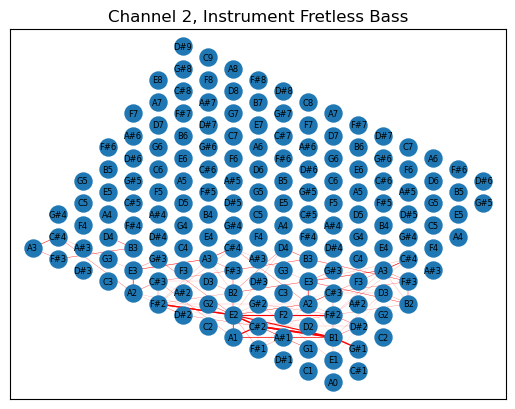

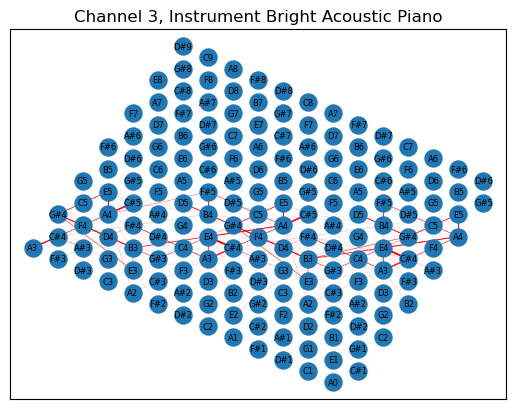

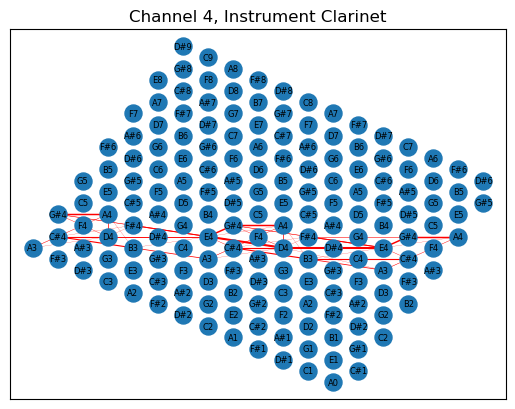

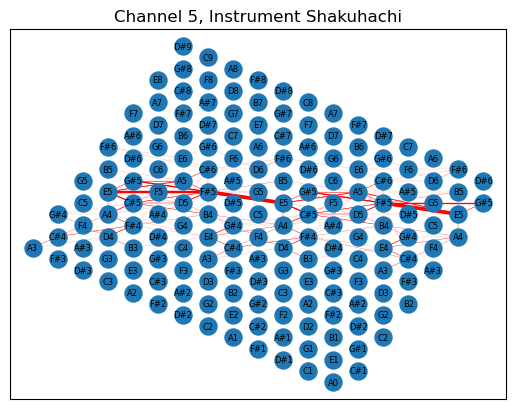

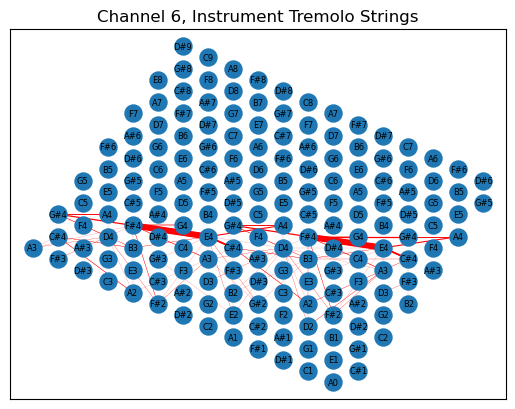

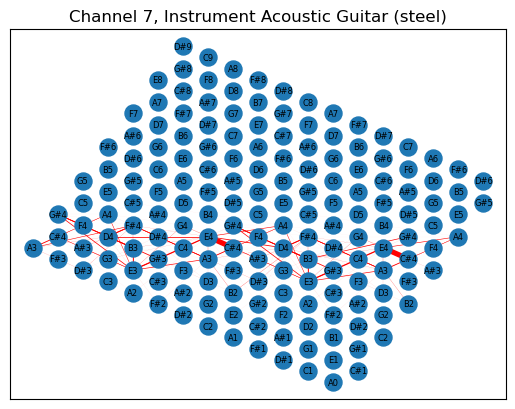

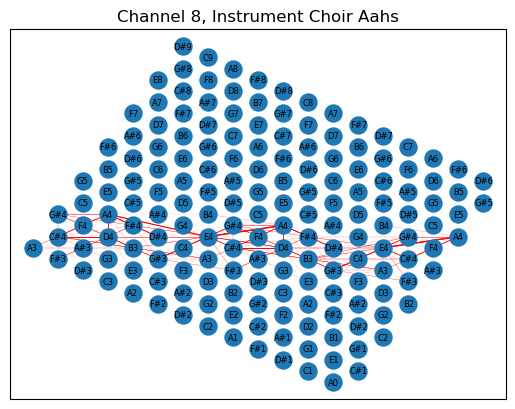

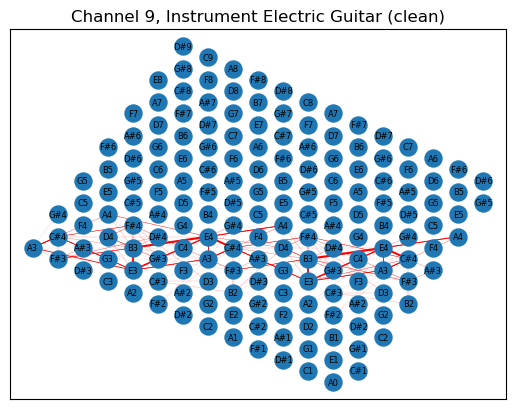

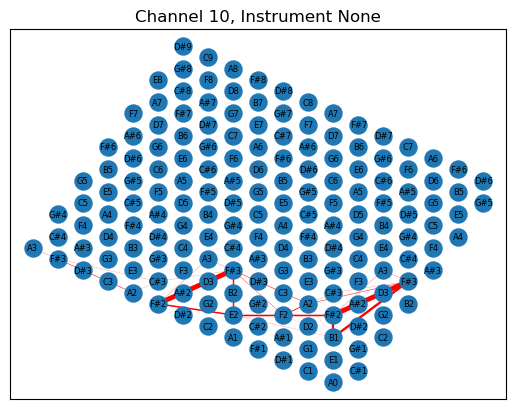

<Figure size 640x480 with 0 Axes>

In [10]:
from utils import GM_INSTRUMENT_NAMES

fer = mido.MidiFile(ABBA_DIR + "Fernando.mid")

MIDI_CHANNEL_COUNT = 16
def type_0_track_to_notes(track: mido.MidiTrack):
    channels = [[] for _ in range(MIDI_CHANNEL_COUNT)]  # Max 16 midi channels
    instruments = [None] * MIDI_CHANNEL_COUNT
    last_note = [None] * MIDI_CHANNEL_COUNT
    transitions = [0] * MIDI_CHANNEL_COUNT
    for msg in track:
        if msg.type == "program_change":
            instruments[msg.channel] = GM_INSTRUMENT_NAMES[msg.program]
        if msg.type == "note_on" and msg.velocity != 0:
            channels[msg.channel].append(msg.note)
            if msg.note != last_note[msg.channel - 1]:
                last_note[msg.channel - 1] = msg.note
                transitions[msg.channel - 1] += 1

    for i, tr in enumerate(transitions):
        if tr < TRANSITION_COUNT_THRESH:
            channels[i] = []
    return channels, instruments

channels, instruments = type_0_track_to_notes(fer.tracks[0])
channel_num = 0
for noteseq, instr in zip(channels, instruments):
    channel_num += 1
    ts = TonnetzSong()
    if len(noteseq) == 0:
        continue
    ts.analyze(noteseq)
    plt.title(f"Channel {channel_num}, Instrument {instr}")
    ts.draw(edge_width_adjust=20)
    plt.figure()


## Analyzing all Songs from an Artist
Instruments are separated and an image is generated showing relevant instruments and their note transitions across the Tonnetz graph

In [11]:
import mido
from tonnetz import TonnetzSong
from matplotlib import pyplot as plt
import utils

MAX_CHANNELS = 9

def graphs_from_song(path, output_root, show=True):

    midi_file = mido.MidiFile(path, clip=True)
    
    name = os.path.splitext(os.path.basename(path))[0] 
    artist = os.path.basename(os.path.dirname(path))
    output_path = os.path.join(output_root, name + ".png")
        
    channels, instruments = utils.mido_to_notes_and_instr(midi_file)

    xplots = 3
    yplots = 3
    fig, axes = plt.subplots(xplots, yplots, figsize=(20, 20))
    
    ts = TonnetzSong()
    idx = 0
    for channel, instr in zip(channels, instruments):
        if len(channel) == 0: continue
        if idx >= xplots * yplots: break
        
        ax = axes[idx // xplots, idx % yplots]
        ts.analyze(channel)
        ts.draw(edge_width_adjust=40, ax=ax)
        ax.set_title(f"{instr}")
        
        idx += 1

    for ax in axes.flatten():
        ax.set_axis_off()

    plt.subplots_adjust(wspace=0, hspace=0.1)
    fig.suptitle(f"{artist}, {name}", y=0.92)
    
    plt.savefig(output_path)
    if show:
        plt.show()
    plt.close(fig)
    
# graphs_from_song("data/clean_midi/ABBA/Dancing Queen.mid")

In [16]:
from tqdm import tqdm

def analyze_artist(data_root, artist, output_root):
    print("Analyzing {}".format(artist))
    
    song_dir = os.path.join(data_root, artist)
    output_dir = os.path.join(output_root, artist)
    os.makedirs(output_dir, exist_ok=True)
    
    for path in tqdm(sorted(os.listdir(song_dir))):
        if any(char.isdigit() for char in path):
            # Skip repeated versions of the song
            continue
        try:
            graphs_from_song(os.path.join(song_dir, path), output_dir, show=False)
        except Exception as e:
            print(f"{path}: {e}")
            

DATA_ROOT = "data/clean_midi"
OUTPUT_ROOT = "analysis/tonnetzImages"


In [17]:
analyze_artist(DATA_ROOT, "ABBA", OUTPUT_ROOT)


Analyzing ABBA


 39%|███▊      | 66/171 [00:15<00:30,  3.45it/s]

I've Been Waiting For You.mid: undefined status byte 0xf9


100%|██████████| 171/171 [00:40<00:00,  4.23it/s]


In [18]:
import random

artists = os.listdir(DATA_ROOT)
for i in range(5):
    art = random.choice(artists)

    analyze_artist(DATA_ROOT, art, OUTPUT_ROOT)


Analyzing Bach Johann Sebastian


  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [00:12<00:00,  6.34it/s]


Analyzing Swingin' Medallions


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Analyzing Warren Zevon


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Analyzing The Commitments


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Analyzing The Byrds


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/test/Super Trooper.png'

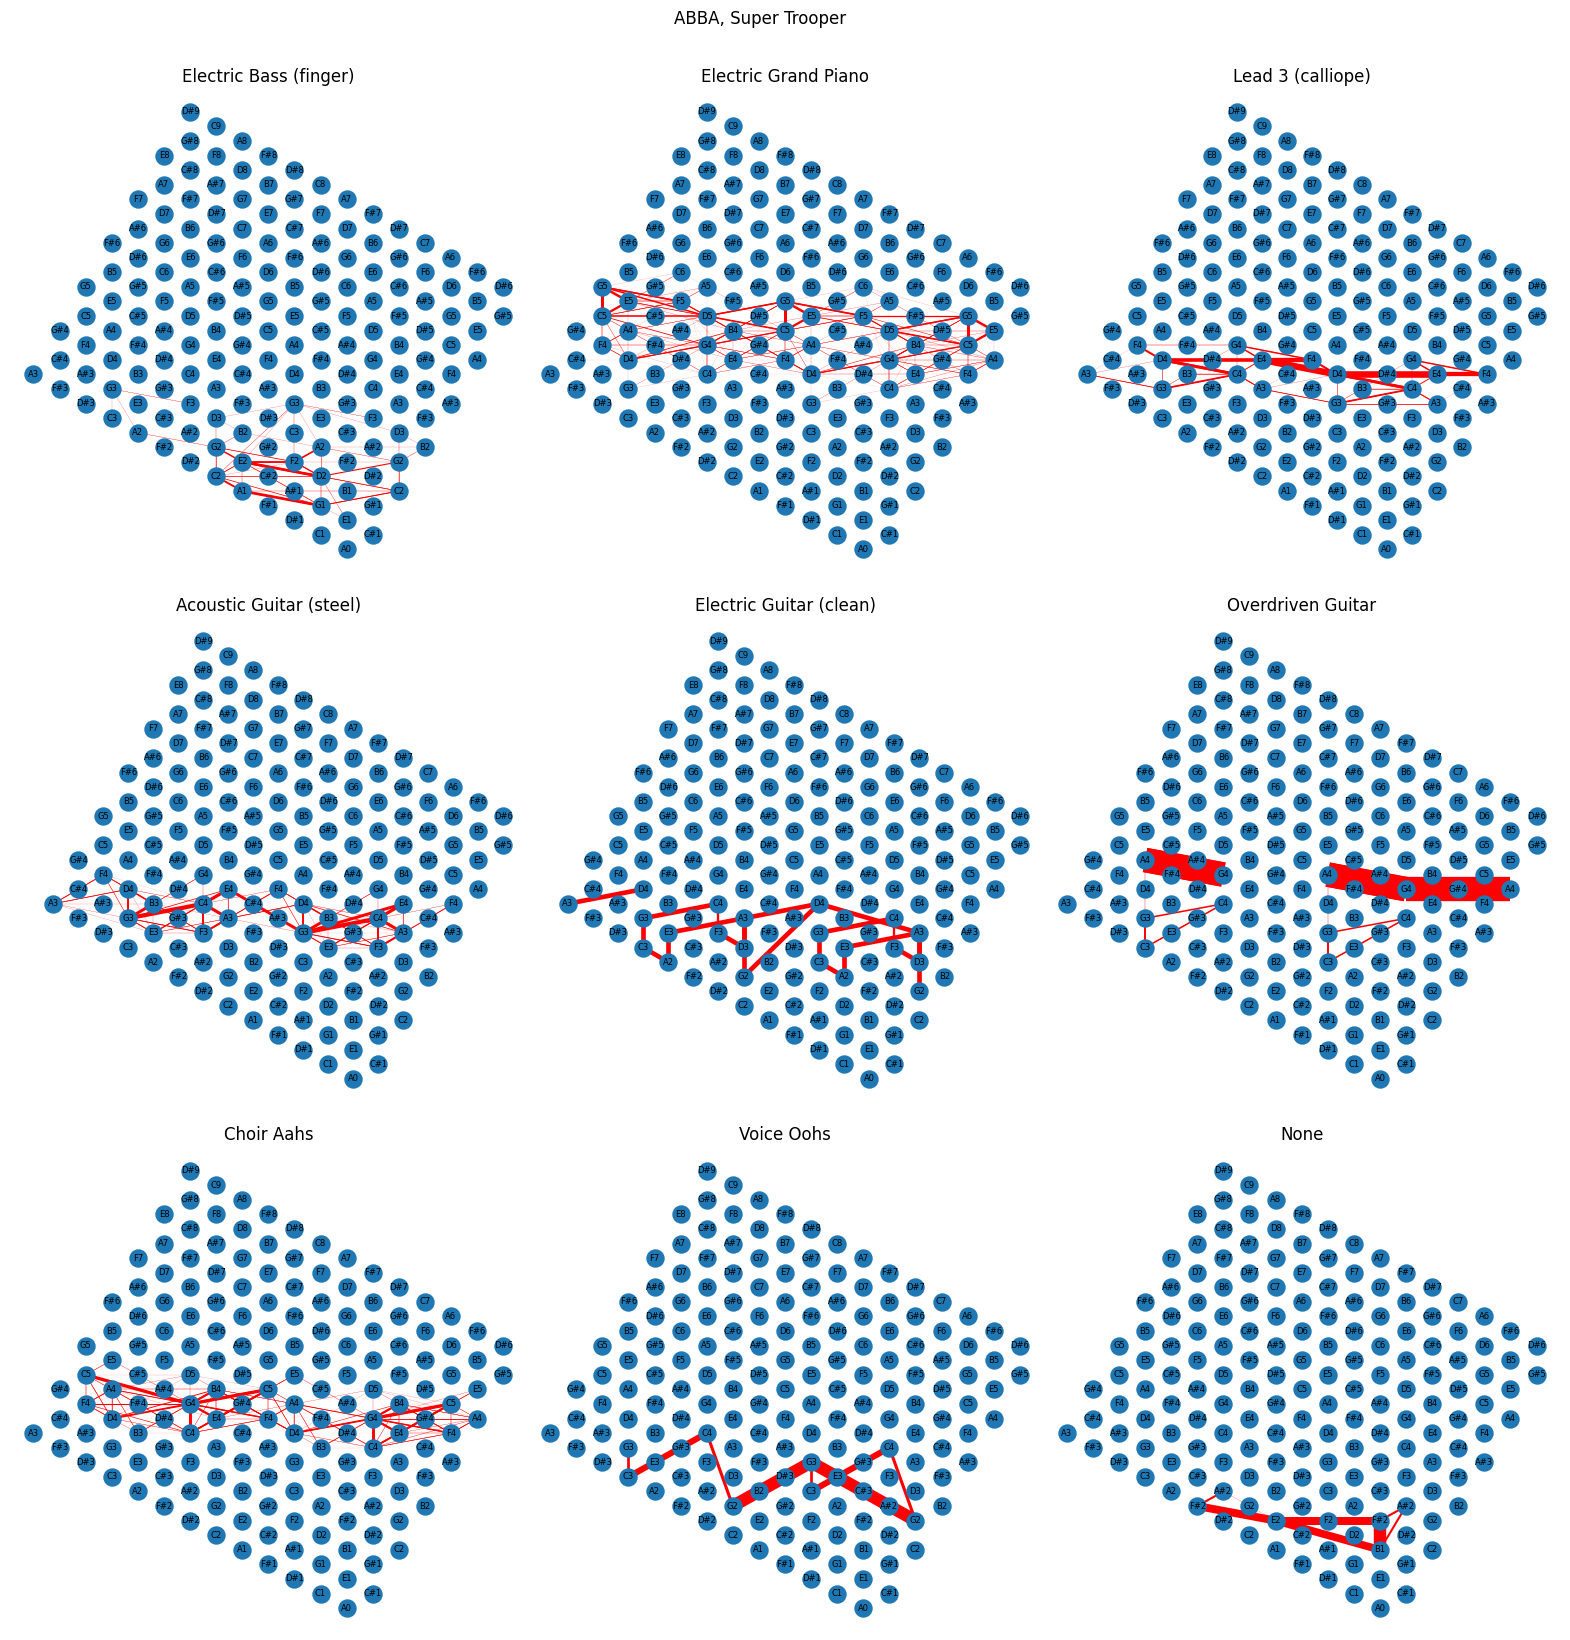

In [19]:
graphs_from_song("data/clean_midi/ABBA/Super Trooper.mid", "data/test", show=True)
graphs_from_song("data/clean_midi/ABBA/Super Trouper.mid", "data/test", show=True)
